# ML Classification
- Learn a model that can clssify which type of given pokemon belongs to based on its **Attack** and **Defense** attributes.
</p>
- **Generative Model** is used in this project.
- This is just a **Binary Classification case** which output is either grass type or normal type.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [2]:
data = pd.read_csv('/Users/yuwenchen/Pokemon-Classifier/Pokemon.csv')
data = pd.DataFrame(data)
data.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [3]:
df = data[['Attack', 'Defense', 'Type 1']]

# extract all grass type pokemon 
grassType = df.loc[df['Type 1'] == 'Grass']
# extract all normal type pokemon
normalType = df.loc[df['Type 1'] == 'Normal']

# only derive 50% grass type pokemon as training set(35)
grass_training = grassType.sample(frac=0.5, replace=False, random_state=1)
# only derive 50% normal type pokemon as training set(49)
normal_training = normalType.sample(frac=0.5, replace=False, random_state=1)

# the 50% rest is testing set
grass_test = grassType[~grassType.isin(grass_training)].dropna()

normal_test = normalType[~normalType.isin(normal_training)].dropna()

In [4]:
testingSet = pd.concat([grass_test, normal_test], ignore_index=True, sort=False)

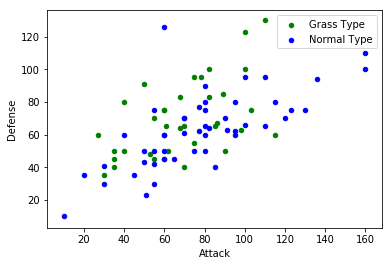

In [5]:
# plot the distribution of training set
ax = grass_training.plot.scatter(x='Attack', y='Defense', c = 'g', label = 'Grass Type')
normal_training.plot.scatter(x='Attack', y='Defense', c = 'b', label = 'Normal Type', ax = ax)
plt.show()

## Classification

- <h4>In this project, Class 1 (C1) is grass type, Class 2 (C2) is normal type.</h4>
<br>
- <h3>Bayes' theorem</h3>
<p>The way to do the classfication is using <strong>Bayes' theorem</strong>. For example, given input x the probability of it belonging to class 1  is P(C1|x), which is:<br><br>
    $$
    P(C_1|x)=\frac{P(C_1)P(x|C_1)}{P(C_1)P(x|C_1)+P(C_2)P(x|C_2)}
    $$<br><br>    
    We can caculate <strong>P(x|C1)</strong> and <strong>P(x|C2)</strong> by using <strong>Multivariate GaussianDistrubution</strong>.
</p>
<br>
- <h3>Multivariate Gaussian Distrubution</h3>
<p>Assume the training set is sampled from a Multivariate Gaussian Distrubution.<br><br>
    Once we get the mean (μ) and corvariance (∑) of the Gausssian, we can use this model (Multivariate Gausssian Distrubution) to caculate the probability of given sample belonging C1 or C2.<br><br>
    Following is the formular of Multivariate Gaussian Distrubution:<br><br>
$$
f_{u,\Sigma}(x)=\frac{1}{(2\pi)^{\frac{D}{2}}}\frac{1}{|\Sigma|^{\frac{1}{2}}}e^{-\frac{1}{2}(x-u)^T\Sigma^{-1}(x-u)}
$$<br><br>
Since the likelihoods of each sample are differnt, we use <strong>Maximum Likelihood</strong> to find a optimal likelihood for all the sample.
</p>

- <h3>Maximum Likelihood</h3>
<p>The mean(μ*) and corvariance(∑*) can generate the highest probability for all the sample.<br><br>
    The way we find μ* and ∑* is using following formulars: (Notice that you could use differential fo find μ* and ∑* but I did not)<br><br>
    $$
    w = {sample \ amount} \\
    u^*,\Sigma^*=\arg \max\limits_{u,\Sigma} L(u,\Sigma) \\
    u^*=\frac{1}{w}\sum\limits_{n=1}^{w}x^n \\
    \Sigma^*=\frac{1}{w}\sum\limits_{n=1}^{w}(x^n-u^*)(x^n-u^*)^T
    $$
</p>

- <h3>Therefore, P(x|C1) is:</h3>
<p>$$
f_{u^*,\Sigma^*}(x)=\frac{1}{(2\pi)^{\frac{D}{2}}}\frac{1}{|\Sigma^*|^{\frac{1}{2}}}e^{-\frac{1}{2}(x-u^*)^T\Sigma^{-1}(x-u^*)}
$$
</p>

In [6]:
num_g = grass_training.shape[0]
num_n = normal_training.shape[0]

# transform the Attack and Defense attributes into 2 dimensional list
grass_list = grass_training.values.T.tolist()
normal_list = normal_training.values.T.tolist()

#### Caculate P(C1) and P(C2) for Bayes' theorem

In [7]:
# 35 grass type pokemon, 49 noaml type pokemon
# grass as Class 1, noaml as Class 2
p_c1 = num_g/(num_g + num_n)
p_c2 = num_n/(num_g + num_n)

#### Caculate P(x|C1) and P(x|C2)

In [8]:
# Function that caculates Maximum Likelihood.
def getMeanCor(pokeList:list, length:int):
    
    # caculate the μ*
    u = 0
    for i in range (length):
        x_n = np.array([[pokeList[0][i]],[pokeList[1][i]]])
        u = u + x_n

    u_max = u/num_g
    u_max = u_max.astype(int)

    # caculate the ∑*
    sig = 0
    for i in range (length):
        # current
        x_n = np.array([[pokeList[0][i]],[pokeList[1][i]]])
        left = x_n - u_max
        right = left.T
        sig = sig + left * right

    sig_max = sig/num_g
    sig_max = sig_max.astype(int)
    
    u_max_flat = list(np.concatenate(u_max).flat)    
    
    return u_max_flat, sig_max

In [9]:
# get Gaussian Distrubution
# grass as Class 1
meanC1, sigC1 = getMeanCor(grass_list, num_g)
# noaml as Class 2
meanC2, sigC2 = getMeanCor(normal_list, num_n)

In [10]:
p_x_C1 = multivariate_normal(mean=meanC1, cov=sigC1)
p_x_C2 = multivariate_normal(mean=meanC2, cov=sigC2)

## Testing Phase
<p>Having all the parameters for Bayes' theorem now, it will give us the probabilty of being which class once we give it a input.<br><br>
If the probability is greater than 0.6 then it belongs to certain category.<br><br>
Use the accuracy formula:
$$
accuracy=\frac{TP+TN}{TP+TN+FP+FN}
$$
</p>

In [11]:
# transform testing set from datafram to list
test = testingSet.values.T.tolist()

In [12]:
# the length of the testing set
tlen = testingSet.shape[0]

In [13]:
#  TP = True Positives, TN = True Negatives, FP = False Positives, and FN = False Negatives.
TP = TN = FP = FN = 0

In [14]:
# learned model P(C1|X)
# if the output > 0.6 then it belongs to C1, else C2

for i in range(tlen):
    temp = [int(test[0][i]) , int(test[1][i])]
    output =  p_x_C1.pdf(temp)*p_c1 / (p_x_C1.pdf(temp)*p_c1 + p_x_C2.pdf(temp)*p_c2)
    
    if output > 0.5: # the prediction is Grass
        if test[2][i] == 'Grass': # if it is actually Grass type
            TP += 1
        else: # if it is actually NOT Grass type
            TN += 1
    else: # the prediction is Normal
        if test[2][i] == 'Normal': # if it is actually Normal type
            FP += 1
        else: # if it is actually NOT Normal type
            FN += 1

In [15]:
# caculate the accuracy
accuracy = (TP+TN) / (TP+TN+FP+FN)
accuracy

0.6547619047619048